In [260]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm
from control import lqr, dare
from dissertation_codes.environment import Particle3D
from dissertation_codes.utils import compute_gamma

In [261]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({
    "text.usetex": True,
})

In [262]:
def digital_converter(signal, total_bit, frac_bit):
    resolution = 2**(-frac_bit)
    if signal >= 0:
        return int(signal/resolution)
    else:
        return int(2**(total_bit)-int(-signal/resolution))

In [274]:
calib_x = 888804.8
calib_y = 634285.1
omegas = [2*np.pi*96236.747, 2*np.pi*100142.8279, 2*np.pi*31517.99568]
gamma = compute_gamma(143e-9/2, 2.2e2, rho=2200, T=293)

m = 2200*4*np.pi*np.power((143e-9)/2, 3)/3
B = (5/m)*np.array([[0, 0, 0],
                        [0,0,0],
                        [0,0,0],
                               [2.41e-16*calib_x, -2.01e-16*calib_y, 0],
                               [2.03e-16*calib_x, 2.41e-16*calib_y, 0],
                               [0, 0, 1e-16]])
A = np.array([[0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1],
              [-omegas[0]**2, 0, 0, -gamma, 0, 0],
              [0, -omegas[1]**2, 0, 0, -gamma, 0],
              [0, 0, -omegas[2]**2, 0, 0, -gamma]
])

g_fb = 10

cost_states = np.array([[omegas[0]/2, 0, 0, 0, 0, 0],
                        [0, omegas[1]/2, 0, 0, 0, 0],
                        [0, 0, omegas[2]/2, 0, 0, 0],
                        [0, 0, 0, omegas[0]/2, 0, 0],
                        [0, 0, 0, 0, omegas[1]/2, 0],
                        [0, 0, 0, 0, 0, omegas[2]/2]])
control_effort = np.array([[1/(2*omegas[0]), 0, 0],
                        [0, 1/(2*omegas[1]), 0],
                        [0, 0, 1/(2*omegas[2])]])


(G_lqr, S, E) = lqr(A, B, cost_states, (1/(g_fb*g_fb))*control_effort)

calib_matrix = np.array([[calib_x**-1, 0, 0, 0, 0, 0],
                         [0, calib_y**-1, 0, 0, 0, 0],
                         [0, 0, 1, 0, 0, 0],
                         [0, 0, 0, calib_x**-1, 0, 0],
                         [0, 0, 0, 0, calib_y**-1, 0],
                         [0, 0, 0, 0, 0, 1]])
G_rp = 3*G_lqr@calib_matrix
G_rp_bit = np.zeros((3, 6))
for j in range(G_rp_bit.shape[1]):
    for i in range(G_rp_bit.shape[0]):
        G_rp_bit[i,j] = digital_converter(G_rp[i,j], 16, 10)
G_rp_bit[0,0], G_rp_bit[0,1], G_rp_bit[0,3], G_rp_bit[0,4], G_rp_bit[1,0], G_rp_bit[1,1], G_rp_bit[1,3], G_rp_bit[1,4]


(15989.0, 19231.0, 15991.0, 19234.0, 51812.0, 23312.0, 51810.0, 23317.0)

In [229]:
G_rp

array([[ 2.23842943e+00,  3.86876968e+00,  0.00000000e+00,
         2.26781869e+00,  3.91516665e+00,  0.00000000e+00],
       [-3.72843345e+00, -6.43764503e+00,  0.00000000e+00,
        -3.77323620e+00, -6.51411641e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  7.42147682e+03,
         0.00000000e+00,  0.00000000e+00,  1.98029546e+06]])

In [91]:
states = 200*np.random.normal(size=(6,1))
new_states = np.zeros((N, 6)) 

for i in tqdm(range(t.shape[0])):
    new_states[i,:] = states[:,0]
    #print(states.shape)
    states = env.step(states, control=-G_lqr@states, delta_t=delta_t, bypass_noise=True)
    #print(G_lqr@states)

  0%|          | 0/31020 [00:00<?, ?it/s]/var/folders/fy/4wjvjmc95f1fv0gy4d27l6_h0000gn/T/ipykernel_48909/3307748872.py:7: RuntimeWarning: overflow encountered in matmul
  states = env.step(states, control=-G_lqr@states, delta_t=delta_t, bypass_noise=True)
/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/dissertation_codes-0.0.1-py3.8.egg/dissertation_codes/environment/particle3D.py:54: RuntimeWarning: invalid value encountered in matmul
/var/folders/fy/4wjvjmc95f1fv0gy4d27l6_h0000gn/T/ipykernel_48909/3307748872.py:7: RuntimeWarning: invalid value encountered in matmul
  states = env.step(states, control=-G_lqr@states, delta_t=delta_t, bypass_noise=True)
100%|██████████| 31020/31020 [00:01<00:00, 29774.16it/s]


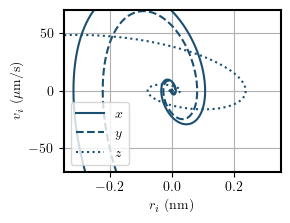

In [6]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']
fig = plt.figure(figsize=(5.4*1.3*10, 10*4.2))
factor = 0.7
fig.set_size_inches(4*factor, 3*factor, forward=True)
plt.plot(1e9*env.zp_x*new_states[:, 0], 1e6*env.zp_px*new_states[:, 3]/env._m_, color=colors[2])
plt.plot(1e9*env.zp_y*new_states[:, 1], 1e6*env.zp_py*new_states[:, 4]/env._m_, color=colors[2], linestyle='dashed')
plt.plot(1e9*env.zp_z*new_states[700:, 2], 1e6*env.zp_pz*new_states[700:, 5]/env._m_, color=colors[2], linestyle='dotted')
plt.xlim([-3.5e-1, 3.5e-1])
plt.grid()
plt.ylim([-70, 70])
plt.legend([r'$x$', r'$y$', r'$z$'], loc='lower left')
plt.xlabel(r'$r_i$ (nm)')
plt.ylabel(r'$v_i$ $(\mu\textrm{m}/\textrm{s})$')
plt.savefig('../../plots/Chapter 3/state_space_trajectory_coupled_actuator.pdf', dpi=300, bbox_inches = 'tight')
plt.show()


In [7]:
gain_num = 100
g_fbs = np.logspace(-2, 1, gain_num)
final_states = np.zeros((gain_num, 6)) 
control_sig = np.zeros((gain_num, 3))
for j, g_fb in tqdm(enumerate(g_fbs)):
    (G_lqr, S, E) = lqr(env.A, env.B, cost_states, control_effort/(g_fb**2))
    states = 100*np.ones(shape=(6,1))
    for i in range(t.shape[0]):
        states = env.step(states, control=-G_lqr@states, delta_t=delta_t, bypass_noise=True)
    final_states[j, :]  = states[:, 0]
    control_sig[j, :] = G_lqr@states[:,0]

100it [01:29,  1.12it/s]


In [8]:
def compute_axis_cost(x, v, weight_x, weight_v, control_effort, control_sig):
    return np.power(x,2)*weight_x+np.power(v,2)*weight_v + control_effort*np.power(control_sig, 2)

In [9]:
j = np.zeros((g_fbs.shape[0],4))
for i in range(final_states.shape[0]):
    x, y, z, px, py, pz = final_states[i,:].ravel()
    ux, uy, uz = control_sig[i,:].ravel()
    j[i,0]  = 0.5*final_states[i,:].T@cost_states@final_states[i,:]+0.5*control_sig[i,:].T@control_effort/(g_fbs[i]**2)@control_sig[i,:]
    j[i,1]  = 0.5*compute_axis_cost(x, px, cost_states[0,0], cost_states[3,3], control_effort[0,0]/(g_fbs[i]**2), control_sig[i, 0])
    j[i,2]  = 0.5*compute_axis_cost(y, py, cost_states[1,1], cost_states[4,4], control_effort[1,1]/(g_fbs[i]**2), control_sig[i, 1])
    j[i,3]  = 0.5*compute_axis_cost(z, pz, cost_states[2,2], cost_states[5,5], control_effort[2,2]/(g_fbs[i]**2), control_sig[i, 2])

#    j[i,2]  = 0.5*final_states[i,:].T@cost_states@final_states[i,:]+0.5*control_sig[i,:].T@control_effort/(g_fb**2)@control_sig[i,:]
#    j[i,3]  = 0.5*final_states[i,:].T@cost_states@final_states[i,:]+0.5*control_sig[i,:].T@control_effort/(g_fb**2)@control_sig[i,:]

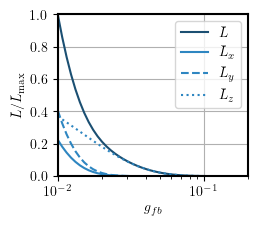

In [10]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']
fig = plt.figure(figsize=(5.4*1.3*10, 10*4.2))
factor = 0.7
fig.set_size_inches(3.5*factor, 3*factor, forward=True)
plt.plot(g_fbs, j[:,0]/max(j[:,0]), color=colors[2])
plt.plot(g_fbs, j[:,1]/max(j[:,0]), color=colors[0], linestyle='solid')
plt.plot(g_fbs, j[:,2]/max(j[:,0]), color=colors[0], linestyle='dashed')
plt.plot(g_fbs, j[:,3]/max(j[:,0]), color=colors[0], linestyle='dotted')
plt.xlim([0.01, 0.2])
plt.ylim([0,1])
plt.xlabel(r'$g_{fb}$')
plt.ylabel(r'$\bar{L}/\bar{L}_{\rm{max}}$')
#plt.yscale('log')
plt.grid()
plt.xscale('log')
plt.legend([r'$\bar{L}$', r'$\bar{L}_x$', r'$\bar{L}_y$', r'$\bar{L}_z$'])
plt.savefig('../../plots/Chapter 3/costs_lqr_coupled_actuator.pdf', dpi=300, bbox_inches = 'tight')

plt.show()

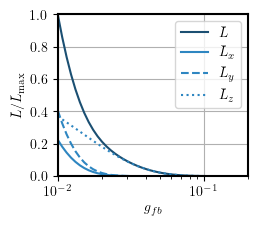

In [ ]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']
fig = plt.figure(figsize=(5.4*1.3*10, 10*4.2))
factor = 0.7
fig.set_size_inches(3.5*factor, 3*factor, forward=True)
plt.plot(g_fbs, j[:,0]/max(j[:,0]), color=colors[2])
plt.plot(g_fbs, j[:,1]/max(j[:,0]), color=colors[0], linestyle='solid')
plt.plot(g_fbs, j[:,2]/max(j[:,0]), color=colors[0], linestyle='dashed')
plt.plot(g_fbs, j[:,3]/max(j[:,0]), color=colors[0], linestyle='dotted')
plt.xlim([0.01, 0.2])
plt.ylim([0,1])
plt.xlabel(r'$g_{fb}$')
plt.ylabel(r'$\bar{L}/\bar{L}_{\rm{max}}$')
#plt.yscale('log')
plt.grid()
plt.xscale('log')
plt.legend([r'$\bar{L}$', r'$\bar{L}_x$', r'$\bar{L}_y$', r'$\bar{L}_z$'])
plt.savefig('../../plots/Chapter 3/costs_lqr_coupled_actuator.pdf', dpi=300, bbox_inches = 'tight')

plt.show()

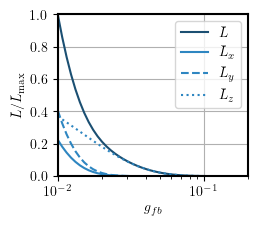

In [ ]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']
fig = plt.figure(figsize=(5.4*1.3*10, 10*4.2))
factor = 0.7
fig.set_size_inches(3.5*factor, 3*factor, forward=True)
plt.plot(g_fbs, j[:,0]/max(j[:,0]), color=colors[2])
plt.plot(g_fbs, j[:,1]/max(j[:,0]), color=colors[0], linestyle='solid')
plt.plot(g_fbs, j[:,2]/max(j[:,0]), color=colors[0], linestyle='dashed')
plt.plot(g_fbs, j[:,3]/max(j[:,0]), color=colors[0], linestyle='dotted')
plt.xlim([0.01, 0.2])
plt.ylim([0,1])
plt.xlabel(r'$g_{fb}$')
plt.ylabel(r'$\bar{L}/\bar{L}_{\rm{max}}$')
#plt.yscale('log')
plt.grid()
plt.xscale('log')
plt.legend([r'$\bar{L}$', r'$\bar{L}_x$', r'$\bar{L}_y$', r'$\bar{L}_z$'])
plt.savefig('../../plots/Chapter 3/costs_lqr_coupled_actuator.pdf', dpi=300, bbox_inches = 'tight')

plt.show()